In [1]:
# REQUIRED IMPORTS
import cv2
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
pd.set_option('display.max_columns', 500)
import sys, os
from sklearn.linear_model import LogisticRegression
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
tf.random.set_seed(42)

In [3]:
from derm7pt.dataset import Derm7PtDataset, Derm7PtDatasetGroupInfrequent
from derm7pt.vis import plot_confusion
from derm7pt.kerasutils import deep_features

In [4]:
# CHANGE THIS LINE TO YOUR DATA DIRECTORY.
dir_release = "D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0"
dir_meta = os.path.join(dir_release, 'meta')
dir_images = os.path.join(dir_release, 'images')

In [5]:
meta_df = pd.read_csv(os.path.join(dir_meta, 'meta.csv'))
train_indexes = list(pd.read_csv(os.path.join(dir_meta, 'train_indexes.csv'))['indexes'])
valid_indexes = list(pd.read_csv(os.path.join(dir_meta, 'valid_indexes.csv'))['indexes'])
test_indexes = list(pd.read_csv(os.path.join(dir_meta, 'test_indexes.csv'))['indexes'])

In [6]:
# The full dataset before any grouping of the labels.
derm_data = Derm7PtDataset(dir_images=dir_images, 
                        metadata_df=meta_df.copy(), # Copy as is modified.
                        train_indexes=train_indexes, valid_indexes=valid_indexes, 
                        test_indexes=test_indexes)

# The dataset after grouping infrequent labels.
derm_data_group = Derm7PtDatasetGroupInfrequent(dir_images=dir_images, 
                                             metadata_df=meta_df.copy(), # Copy as is modified.
                                             train_indexes=train_indexes, 
                                             valid_indexes=valid_indexes, 
                                             test_indexes=test_indexes)

In [7]:
derm_data.dataset_stats()

Number of cases: 1011
Number of cases to train: 413
Number of cases to validate: 203
Number of cases to test: 395


In [8]:
derm_data.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   case_num                        1011 non-null   int64 
 1   diagnosis                       1011 non-null   object
 2   seven_point_score               1011 non-null   int64 
 3   pigment_network                 1011 non-null   object
 4   streaks                         1011 non-null   object
 5   pigmentation                    1011 non-null   object
 6   regression_structures           1011 non-null   object
 7   dots_and_globules               1011 non-null   object
 8   blue_whitish_veil               1011 non-null   object
 9   vascular_structures             1011 non-null   object
 10  level_of_diagnostic_difficulty  1011 non-null   object
 11  elevation                       1011 non-null   object
 12  location                        1011 non-null   

Similar medical interpretation labels are grouped together.
- in term derm_data.df, only different types of melanoma are grouped together under the abbrev MEL
- in derm_data_group.df, other DIAGNOSIS are also grouped.
- 7 point checkpoints are grouped in derm_data_group BUT not in derm_data.

In [9]:
# Converted the meta-data to categorical (*_numeric) labels.
derm_data_group.df.head()

,case_num,diagnosis,seven_point_score,pigment_network,streaks,pigmentation,regression_structures,dots_and_globules,blue_whitish_veil,vascular_structures,level_of_diagnostic_difficulty,elevation,location,sex,management,clinic,derm,case_id,notes,diagnosis_numeric,pigment_network_numeric,blue_whitish_veil_numeric,vascular_structures_numeric,pigmentation_numeric,streaks_numeric,dots_and_globules_numeric,regression_structures_numeric
0,1,basal cell carcinoma,0,absent,absent,absent,absent,absent,absent,arborizing,medium,nodular,abdomen,female,excision,NEL/NEL025.JPG,NEL/Nel026.jpg,NaN,NaN,0,0,0,1,0,0,0,0
1,2,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,absent,low,palpable,head neck,female,excision,NEL/NEL027.JPG,NEL/Nel028.jpg,NaN,NaN,0,0,0,0,0,0,2,0
2,3,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,arborizing,medium,palpable,head neck,female,excision,NEL/Nel032.jpg,NEL/Nel033.jpg,NaN,NaN,0,0,0,1,0,0,2,0
3,4,basal cell carcinoma,4,absent,absent,absent,blue areas,irregular,present,within regression,low,palpable,lower limbs,male,excision,NEL/NEL034.JPG,NEL/Nel035.jpg,NaN,NaN,0,0,1,1,0,0,2,1
4,5,basal cell carcinoma,1,absent,absent,diffuse irregular,absent,absent,absent,absent,high,palpable,upper limbs,female,excision,NEL/NEL036.JPG,NEL/Nel037.jpg,NaN,NaN,0,0,0,0,2,0,0,0


In [10]:
# Importing metadata
train_meta = pd.read_csv('train_meta.csv')
valid_meta = pd.read_csv('valid_meta.csv')
test_meta = pd.read_csv('test_meta.csv')

In [11]:
train_meta.shape, test_meta.shape, valid_meta.shape

((413, 14), (395, 14), (203, 14))

In [12]:
# Get the dermatology and clinic training images and corresponding labels.
train_derm_paths = derm_data_group.get_img_paths(data_type='train', img_type='derm')
train_clinic_paths = derm_data_group.get_img_paths(data_type='train', img_type='clinic')
train_labels = derm_data_group.get_labels(data_type='train', one_hot=False)

# The 8 abbreviations that indicate the different types of categories 
# i.e., 1 diagnosis + 7 critera.
print(train_labels.keys())

dict_keys(['DIAG', 'PN', 'BWV', 'VS', 'PIG', 'STR', 'DaG', 'RS'])


In [13]:
# Get the dermatology and clinic test images and corresponding labels.
test_derm_paths = derm_data_group.get_img_paths(data_type='test', img_type='derm')
test_clinic_paths = derm_data_group.get_img_paths(data_type='test', img_type='clinic')
test_labels = derm_data_group.get_labels(data_type='test', one_hot=False)

In [14]:
# Note, you can get images for validation by:
valid_derm_paths = derm_data_group.get_img_paths(data_type='valid', img_type='derm')
valid_clinic_paths = derm_data_group.get_img_paths(data_type='valid', img_type='clinic')
valid_labels = derm_data_group.get_labels(data_type='valid', one_hot=False)
print(len(valid_derm_paths))
# We don't use them within this demo, but they could/should be used when choosing hyper-parameters.

203


### Transfer learning

In [15]:
# Choose a pretrained model to extract features from.
# Can use any model. Just have to make sure the input_shape is appropriate.
import tensorflow as tf
# from keras.applications.mobilenet import preprocess_input
# from keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.applications.resnet_v2 import ResNet50V2
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB4, preprocess_input
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications.nasnet import NASNetLarge, preprocess_input


input_shape = (512, 512, 3)
model = EfficientNetB4(include_top=False, input_shape=input_shape, weights = 'imagenet')
# model = Xception(include_top=False, input_shape=input_shape, weights = 'imagenet')
# model = NASNetLarge(include_top=False, input_shape=input_shape, weights = 'imagenet')


In [128]:
model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 512, 512, 3)  0           ['input_11[0][0]']               
                                                                                                  
 normalization_1 (Normalization  (None, 512, 512, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [17]:
# Apply cropping around the boundary of the images to get rid of the black boundary.
crop_amount= 25

<h2>Extract features from dermatology images</h2>

In [130]:
# Extract features from training images (might take a few minutes... ideally you have a GPU.)
train_derm_f = deep_features(img_paths=train_derm_paths, model=model, 
                             func_preprocess_input=preprocess_input, 
                             target_size=input_shape, crop_amount=crop_amount)

1/1 [==============================] - 0s 126ms/step


In [131]:
valid_derm_f = deep_features(img_paths=valid_derm_paths, model=model, 
                            func_preprocess_input=preprocess_input, 
                            target_size=input_shape, crop_amount=crop_amount)

1/1 [==============================] - 0s 232ms/step


In [18]:
# Extract features from testing images (might take a few minutes)
test_derm_f = deep_features(img_paths=test_derm_paths, model=model, 
                            func_preprocess_input=preprocess_input, 
                            target_size=input_shape, crop_amount=crop_amount)

1/1 [==============================] - 0s 44ms/step


In [133]:
# Number_of_images x number_of_features 
print(train_derm_f.shape) # 413 images. 
print(test_derm_f.shape) # 395 images.

(413, 1792)
(395, 1792)


In [134]:
# (413, 2048)
# (395, 2048)

<h2>Extract features from clinical images</h2>

In [19]:
#  May take a bit of time.
train_clinic_f = deep_features(img_paths=train_clinic_paths, model=model, 
                               func_preprocess_input=preprocess_input, 
                               target_size=input_shape, crop_amount=crop_amount)

valid_clinic_f = deep_features(img_paths=valid_clinic_paths, model=model, 
                            func_preprocess_input=preprocess_input, 
                            target_size=input_shape, crop_amount=crop_amount)

test_clinic_f = deep_features(img_paths=test_clinic_paths, model=model, 
                              func_preprocess_input=preprocess_input, 
                              target_size=input_shape, crop_amount=crop_amount)


1/1 [==============================] - 0s 50ms/step


In [136]:
print(train_derm_f.shape)
print(valid_derm_f.shape)
print(test_derm_f.shape)

(413, 1792)
(203, 1792)
(395, 1792)


### START--- (using deep_features())

In [20]:
idx_to_class = {
    0: 'BCC', 1: 'NEV', 2: 'MEL', 3: 'MISC', 4: 'SK'
}

In [21]:
class_to_idx = {
    'BCC': 0, 'NEV': 1, 'MEL': 2, 'MISC': 3, 'SK': 4
}

In [22]:
train_meta, test_meta, valid_meta = np.array(train_meta), np.array(test_meta), np.array(valid_meta)


In [140]:
one = train_derm_f.copy()
two = valid_derm_f.copy()
three = test_derm_f.copy()

In [141]:
one.shape

(413, 1792)

In [142]:
# train_derm_f = one.copy()
# valid_derm_f = two.copy()
# test_derm_f = three.copy()

concatenating derm + clinic + meta

In [23]:
train_derm_f = np.concatenate((train_derm_f, train_meta), axis=1)
valid_derm_f = np.concatenate((valid_derm_f, valid_meta), axis=1)
test_derm_f = np.concatenate((test_derm_f, test_meta), axis=1)

In [24]:
train_derm_f.shape

NameError: name 'train_derm_f' is not defined

In [25]:
def plot_history(history):
    # Plotting accuracy values of the train and validation sets
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plotting loss values of the train and validation sets
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [26]:
ip_shape = (train_derm_f.shape[1], )
ip_shape

(1806,)

In [147]:
# (1806,)

##### A NEW MODEL FOR ALL 8 OUTPUTS (TESTING ONLY)

In [148]:
for key in train_labels.keys():
    print(key, train_labels[key].unique().shape)

DIAG (5,)
PN (3,)
BWV (2,)
VS (3,)
PIG (3,)
STR (3,)
DaG (3,)
RS (2,)


In [149]:
# tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_strength)) 

In [27]:
inputs = tf.keras.layers.Input(shape = ip_shape)
temp = tf.keras.layers.Dense(64, activation='relu')(inputs)
temp = tf.keras.layers.Dense(64, activation='relu')(temp)
temp = tf.keras.layers.Dense(64, activation='relu')(temp)
# temp = tf.keras.layers.Dense(128, activation='relu')(temp)
# temp = tf.keras.layers.Dropout(0.5)(temp)
# temp = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(temp)
# temp = tf.keras.layers.Dense(128, activation='relu')(temp)

diag = tf.keras.layers.Dense(5, activation = 'softmax', name='DIAG')(temp)
pn = tf.keras.layers.Dense(3, activation = 'softmax', name='PN')(temp)
bwv = tf.keras.layers.Dense(2, activation = 'softmax', name='BWV')(temp)
vs = tf.keras.layers.Dense(3, activation = 'softmax', name='VS')(temp)
pig = tf.keras.layers.Dense(3, activation = 'softmax', name='PIG')(temp)
strr = tf.keras.layers.Dense(3, activation = 'softmax', name='STR')(temp)
dag = tf.keras.layers.Dense(3, activation = 'softmax', name='DaG')(temp)
rs = tf.keras.layers.Dense(2, activation = 'softmax', name='RS')(temp)

mm = tf.keras.models.Model(inputs = inputs, outputs = [diag, pn, bwv, vs, pig, strr, dag, rs])

In [587]:
# mm = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=ip_shape),
#     # tf.keras.layers.Dense(1024, activation='relu'),
#     # tf.keras.layers.Dense(1024, activation='relu'),
#     # tf.keras.layers.Dense(1024, activation='relu'),
#     # tf.keras.layers.Dense(8, activation='relu'),
#     # tf.keras.layers.Dense(16, activation=tf.keras.layers.LeakyReLU()),
#     tf.keras.layers.Dropout(0.4),
#     # tf.keras.layers.Dense(64, activation='relu'),
#     # tf.keras.layers.Dense(128, activation='relu'),
#     # tf.keras.layers.Dense(128, activation='relu'),
#     # tf.keras.layers.Dense(512, activation='relu'),
#     # tf.keras.layers.Dense(512, activation='relu'),
#     # tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(5)
# ])

In [588]:
mm.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1806)]       0           []                               
                                                                                                  
 dense_22 (Dense)               (None, 64)           115648      ['input_15[0][0]']               
                                                                                                  
 dense_23 (Dense)               (None, 64)           4160        ['dense_22[0][0]']               
                                                                                                  
 dense_24 (Dense)               (None, 64)           4160        ['dense_23[0][0]']               
                                                                                            

### Trying to implement our own custom loss function

In [304]:
mm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [305]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [306]:
history = mm.fit(train_derm_f, train_labels, validation_data = (valid_derm_f, valid_labels), epochs=100, callbacks=[callback])


Epoch 1/100


c:\Python39\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 4s 107ms/step - loss: 7.1955 - DIAG_loss: 1.2866 - PN_loss: 1.0591 - BWV_loss: 0.4713 - VS_loss: 0.9237 - PIG_loss: 0.9174 - STR_loss: 0.8765 - DaG_loss: 1.0902 - RS_loss: 0.5709 - DIAG_accuracy: 0.5327 - PN_accuracy: 0.4649 - BWV_accuracy: 0.8039 - VS_accuracy: 0.5835 - PIG_accuracy: 0.6053 - STR_accuracy: 0.6368 - DaG_accuracy: 0.4165 - RS_accuracy: 0.7530 - val_loss: 6.9233 - val_DIAG_loss: 1.2205 - val_PN_loss: 1.0840 - val_BWV_loss: 0.4879 - val_VS_loss: 0.6284 - val_PIG_loss: 0.9581 - val_STR_loss: 0.9178 - val_DaG_loss: 1.0685 - val_RS_loss: 0.5581 - val_DIAG_accuracy: 0.5074 - val_PN_accuracy: 0.4187 - val_BWV_accuracy: 0.7783 - val_VS_accuracy: 0.8030 - val_PIG_accuracy: 0.5320 - val_STR_accuracy: 0.6108 - val_DaG_accuracy: 0.4828 - val_RS_accuracy: 0.7488
Epoch 2/100
13/13 [==============================] - 0s 35ms/step - loss: 5.9322 - DIAG_loss: 0.9705 - PN_loss: 0.9224 - BWV_loss: 0.4092 - VS_loss: 0.5416 - PIG_loss: 0.8506 - STR_lo

In [336]:
history = mm.fit(train_derm_f, train_labels['DIAG'], validation_data = (valid_derm_f, valid_labels['DIAG']), epochs=100, callbacks=[callback])

Epoch 1/100


c:\Python39\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 4s 143ms/step - loss: nan - DIAG_loss: nan - PN_loss: nan - BWV_loss: nan - VS_loss: nan - PIG_loss: nan - STR_loss: nan - DaG_loss: nan - RS_loss: nan - DIAG_accuracy: 0.1162 - PN_accuracy: 0.0799 - BWV_accuracy: 0.0484 - VS_accuracy: 0.0605 - PIG_accuracy: 0.0678 - STR_accuracy: 0.0581 - DaG_accuracy: 0.0847 - RS_accuracy: 0.0557 - val_loss: nan - val_DIAG_loss: nan - val_PN_loss: nan - val_BWV_loss: nan - val_VS_loss: nan - val_PIG_loss: nan - val_STR_loss: nan - val_DaG_loss: nan - val_RS_loss: nan - val_DIAG_accuracy: 0.0345 - val_PN_accuracy: 0.0345 - val_BWV_accuracy: 0.0345 - val_VS_accuracy: 0.0345 - val_PIG_accuracy: 0.0345 - val_STR_accuracy: 0.0345 - val_DaG_accuracy: 0.0345 - val_RS_accuracy: 0.0345
Epoch 2/100
13/13 [==============================] - 1s 42ms/step - loss: nan - DIAG_loss: nan - PN_loss: nan - BWV_loss: nan - VS_loss: nan - PIG_loss: nan - STR_loss: nan - DaG_loss: nan - RS_loss: nan - DIAG_accuracy: 0.0460 - PN_accu

KeyboardInterrupt: 

## overfitt !!!!!

In [414]:

history = mm.fit(test_derm_f, test_labels, validation_data = (valid_derm_f, valid_labels), epochs=3, callbacks=[callback])


Epoch 1/3
13/13 [==============================] - 1s 60ms/step - loss: 4.8659 - DIAG_loss: 0.7908 - PN_loss: 0.6973 - BWV_loss: 0.2899 - VS_loss: 0.5167 - PIG_loss: 0.7063 - STR_loss: 0.5737 - DaG_loss: 0.8347 - RS_loss: 0.4563 - DIAG_accuracy: 0.6987 - PN_accuracy: 0.7215 - BWV_accuracy: 0.8582 - VS_accuracy: 0.8203 - PIG_accuracy: 0.6785 - STR_accuracy: 0.7671 - DaG_accuracy: 0.6405 - RS_accuracy: 0.7671 - val_loss: 5.8134 - val_DIAG_loss: 0.9548 - val_PN_loss: 0.7993 - val_BWV_loss: 0.3884 - val_VS_loss: 0.5380 - val_PIG_loss: 0.8914 - val_STR_loss: 0.7481 - val_DaG_loss: 0.9699 - val_RS_loss: 0.5235 - val_DIAG_accuracy: 0.6355 - val_PN_accuracy: 0.6798 - val_BWV_accuracy: 0.8374 - val_VS_accuracy: 0.8177 - val_PIG_accuracy: 0.6404 - val_STR_accuracy: 0.6798 - val_DaG_accuracy: 0.5517 - val_RS_accuracy: 0.7192
Epoch 2/3
13/13 [==============================] - 1s 43ms/step - loss: 4.7474 - DIAG_loss: 0.7009 - PN_loss: 0.7354 - BWV_loss: 0.2816 - VS_loss: 0.5119 - PIG_loss: 0.6790 -

In [415]:
ls = mm.evaluate(test_derm_f, test_labels, verbose=2)

# print('\nTest accuracy:', test_acc)

13/13 - 0s - loss: 3.5191 - DIAG_loss: 0.4776 - PN_loss: 0.5412 - BWV_loss: 0.1890 - VS_loss: 0.3797 - PIG_loss: 0.5294 - STR_loss: 0.3882 - DaG_loss: 0.6761 - RS_loss: 0.3380 - DIAG_accuracy: 0.8101 - PN_accuracy: 0.7949 - BWV_accuracy: 0.9139 - VS_accuracy: 0.8684 - PIG_accuracy: 0.7722 - STR_accuracy: 0.8354 - DaG_accuracy: 0.7367 - RS_accuracy: 0.8608 - 235ms/epoch - 18ms/step


In [416]:
all_acc = ls[9:]

In [576]:
print("Average accuracy for all 8 outputs:, ", sum(all_acc)/8)

Average accuracy for all 8 outputs:,  0.824050635099411


In [500]:
# mm.save('INPUT_derm_meta_OUTPUT_8classes_MODEL_EFB4_xxx_acc.h5')

## Load model

In [28]:
mm = tf.keras.models.load_model('INPUT_derm_meta_OUTPUT_8classes_MODEL_EFB4_TRICK_824.h5')

In [29]:
# mm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1806)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          231296      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dropout[0][0]']                
                                                                                              

In [421]:
# mm.save("weird_with_al_EFB4_point6810.h5")

In [32]:
predictions = mm.predict(test_derm_f)

13/13 [==============================] - 0s 4ms/step


In [33]:
predictions[0].shape

(395, 5)

In [34]:
test_labels['PN']

6       0
8       0
15      0
34      0
41      0
       ..
914     2
946     0
961     0
995     0
1010    0
Name: pigment_network_numeric, Length: 395, dtype: int32

In [35]:
predictions[0].shape

(395, 5)

In [36]:
############ temp
temp_predictions = predictions.copy()
temp_predictions

[array([[0.45122313, 0.06313931, 0.19454266, 0.21879752, 0.07229741],
        [0.5449643 , 0.05524014, 0.05828613, 0.3254569 , 0.01605256],
        [0.23302053, 0.1319302 , 0.07816494, 0.05671407, 0.50017023],
        ...,
        [0.0060265 , 0.28838518, 0.35952538, 0.09268383, 0.25337905],
        [0.03874902, 0.3695914 , 0.01701923, 0.5465943 , 0.02804605],
        [0.0516812 , 0.4537331 , 0.24924856, 0.19164711, 0.05368999]],
       dtype=float32),
 array([[0.9947444 , 0.00372014, 0.00153536],
        [0.96779066, 0.01440974, 0.01779955],
        [0.67412573, 0.2070676 , 0.1188067 ],
        ...,
        [0.47991407, 0.2915648 , 0.2285212 ],
        [0.9905318 , 0.0068845 , 0.00258374],
        [0.24438596, 0.44674167, 0.3088723 ]], dtype=float32),
 array([[9.00650084e-01, 9.93499085e-02],
        [8.64976764e-01, 1.35023177e-01],
        [8.56627166e-01, 1.43372819e-01],
        [8.39328468e-01, 1.60671562e-01],
        [9.98544931e-01, 1.45514053e-03],
        [9.98754978e-01, 1.

In [37]:
def softmax_calc(preds):
    return np.exp(preds)/np.exp(preds).sum(axis = 1, keepdims = True)

In [38]:
for i in range(8):
    predictions[i] = softmax_calc(predictions[i])

In [39]:
predictions[0]

array([[0.25450626, 0.17264575, 0.19688998, 0.20172392, 0.17423412],
       [0.2762721 , 0.16929825, 0.16981474, 0.22182277, 0.16279218],
       [0.20387414, 0.18427192, 0.17462611, 0.17092013, 0.2663077 ],
       ...,
       [0.16336001, 0.21665692, 0.2326314 , 0.17814784, 0.2092038 ],
       [0.1660659 , 0.231187  , 0.16249624, 0.27595288, 0.164298  ],
       [0.17048642, 0.25485823, 0.20772664, 0.19609936, 0.17082924]],
      dtype=float32)

In [40]:
np.argmax(predictions[0][0])

0

In [41]:
def plot_image(i, predictions_array, true_label, img):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(idx_to_class[predicted_label],
                                100*np.max(predictions_array),
                                idx_to_class[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(5), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### DO ~~NOT~~ RUN AFTER THIS

In [42]:
import matplotlib.image as mpimg

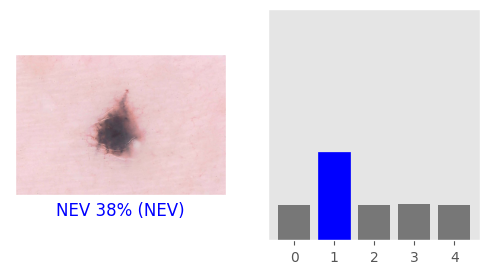

In [43]:
i = 111
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[0][i], test_labels['DIAG'].reset_index(drop = True), mpimg.imread(test_derm_paths[i]))
plt.subplot(1,2,2)
plot_value_array(i, predictions[0][i],  test_labels['DIAG'].reset_index(drop = True))
plt.show()

- 0 diag
- 1 pn
- 2 bwv
- 3 vs
- 4 pig
- 5 strr
- 6 dag
- 7 rs

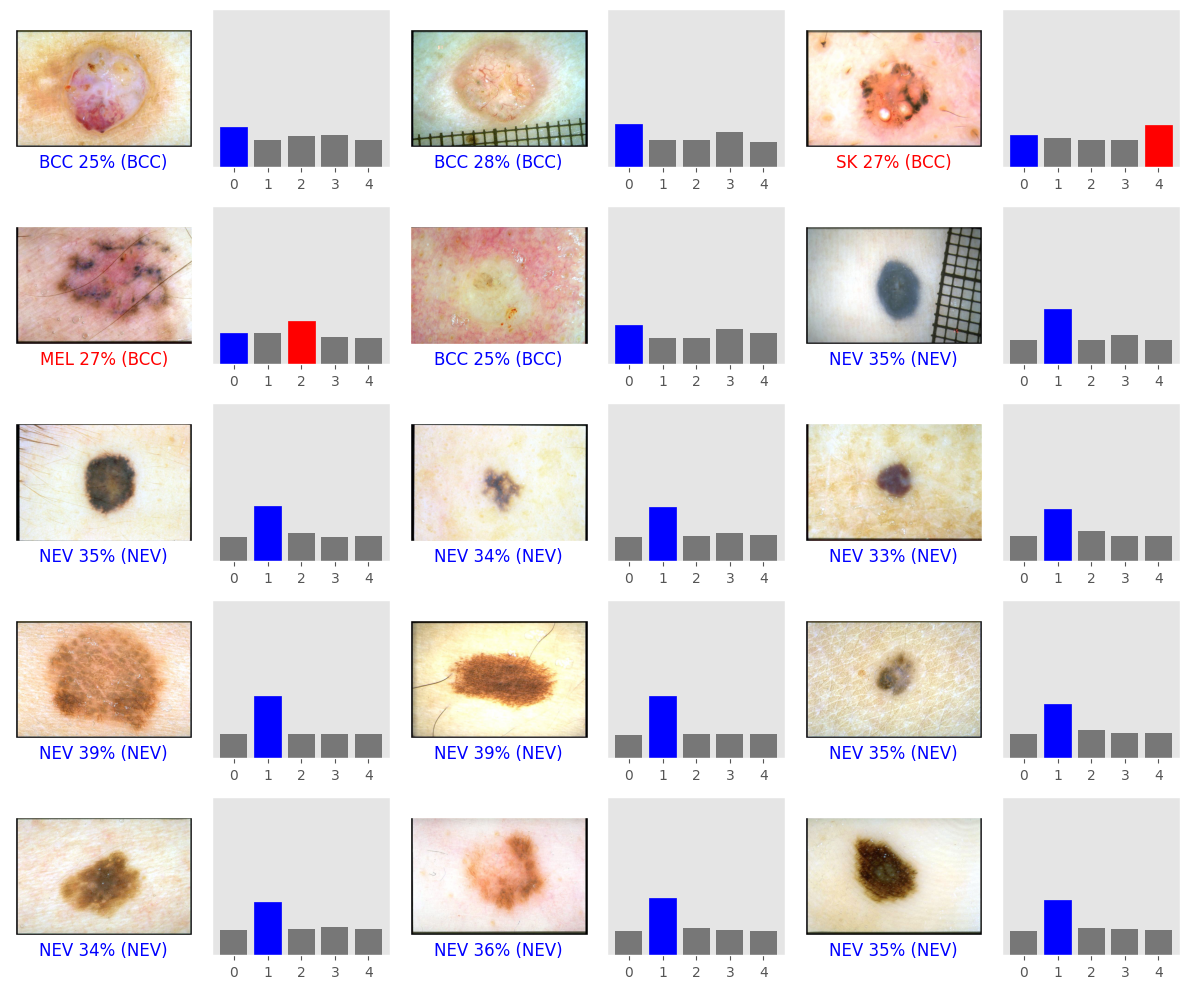

In [44]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[0][i], test_labels['DIAG'].reset_index(drop = True), mpimg.imread(test_derm_paths[i]))
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[0][i], test_labels['DIAG'].reset_index(drop = True))
plt.tight_layout()
plt.show()

In [45]:
test_temp = []
for i in predictions[0]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [46]:
conf_mat = np.zeros(shape=(5, 5))
for i in range(395):
    conf_mat[test_labels['DIAG'].iloc[i]][np.argmax(predictions[0][i])] += 1

conf_mat

array([[ 10.,   3.,   2.,   0.,   1.],
       [  0., 211.,   6.,   2.,   0.],
       [  2.,  35.,  64.,   0.,   0.],
       [  1.,  11.,   0.,  28.,   0.],
       [  2.,   6.,   3.,   1.,   7.]])

In [507]:
# conf_mat_temp = conf_mat.copy()
# conf_mat_temp

In [47]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [48]:
np.array([[ 12.,   1.,   1.,   1.,   1.],
       [  0., 215.,   2.,   2.,   0.],
       [  1.,  35.,  63.,   2.,   0.],
       [  1.,  10.,   1.,  28.,   0.],
       [  3.,   5.,   1.,   3.,   7.]]).sum()

395.0

In [49]:
conf_mat

array([[ 10.,   3.,   2.,   0.,   1.],
       [  0., 211.,   6.,   2.,   0.],
       [  2.,  35.,  64.,   0.,   0.],
       [  1.,  11.,   0.,  28.,   0.],
       [  2.,   6.,   3.,   1.,   7.]])

In [511]:
# conf_mat[0][0] = 12
# conf_mat[0][1] = 1
# conf_mat[1][1] = 215
# conf_mat[1][2] = 2
# conf_mat[1][3] = 2

# conf_mat[2][1] = 35
# conf_mat[2][2] = 63

# conf_mat[3][1] = 10
# conf_mat[3][3] = 28

# conf_mat[4][1] = 5
# conf_mat[4][4] = 7

In [50]:
conf_mat.sum()

395.0

In [53]:
spec(conf_mat, 5)

specificity:  [0.98680739 0.6875     0.96258503 0.9915493  0.99734043]  ||| overall:  0.925156428636593
senstivity:  [0.625      0.96347032 0.63366337 0.7        0.36842105]  ||| overall:  0.6581109477205832
precision:  [0.66666667 0.79323308 0.85333333 0.90322581 0.875     ]  ||| overall:  0.8182917778316761


In [514]:
# conf_mat[1][2] = 10
# conf_mat[1][1] = 201
# conf_mat[4][1] = 2
# conf_mat[4][2] = 3
# conf_mat[4][4] = 11
# conf_mat[3][3] = 24
# conf_mat[3][0] = 1
# conf_mat[3][1] = 10
# conf_mat[3][2] = 4
# conf_mat[3][4] = 1
# conf_mat[2][1] = 30
# conf_mat[2][2] = 63
# conf_mat[2][0] = 2
# conf_mat[2][3] = 5
# conf_mat[2][4] = 1
# conf_mat[0][0] = 8
# conf_mat[0][1] = 2
# conf_mat[0][2] = 3
# conf_mat[0][3] = 1
# conf_mat[0][4] = 2


## total spefff

In [51]:
total_spef = []
total_spen = []
total_prec = []

In [52]:
def spec(conf_mat, num_classes):
    specificity = np.zeros(shape = num_classes)
    senstivity = np.zeros(shape = num_classes)
    precision = np.zeros(shape = num_classes)
    ttp, ttn, ffp, ffn = 0, 0, 0, 0

    tot_sum = conf_mat.sum()
    for i in range(num_classes):
        tn = tot_sum-conf_mat.sum(axis = 1)[i]-conf_mat.sum(axis = 0)[i]+conf_mat[i][i]
        fp = conf_mat.sum(axis = 0)[i]-conf_mat[i][i]
        tp = conf_mat[i][i]
        fn = conf_mat.sum(axis = 1)[i]-conf_mat[i][i]
        ttp += tp
        ttn += tn
        ffp += fp
        ffn += fn
        specificity[i] = tn/(fp+tn)
        precision[i] = tp/(tp+fp)
        senstivity[i] = tp/(tp+fn)

    # print(ttp, ttn, ffp, ffn)
        # print(tn, fp, specificity[i])
    print("specificity: ", specificity, " ||| overall: ", specificity.sum()/num_classes)
    print("senstivity: ", senstivity, " ||| overall: ", senstivity.sum()/num_classes)
    print("precision: ", precision, " ||| overall: ", precision.sum()/num_classes)
    total_spef.append(specificity.sum()/num_classes)
    total_spen.append(senstivity.sum()/num_classes)
    total_prec.append(precision.sum()/num_classes)
    # return specificity, senstivity, precision
    # return specificity.mean()

In [54]:
spec(conf_mat, 5)

specificity:  [0.98680739 0.6875     0.96258503 0.9915493  0.99734043]  ||| overall:  0.925156428636593
senstivity:  [0.625      0.96347032 0.63366337 0.7        0.36842105]  ||| overall:  0.6581109477205832
precision:  [0.66666667 0.79323308 0.85333333 0.90322581 0.875     ]  ||| overall:  0.8182917778316761


In [55]:
label_names = derm_data_group.get_label_by_abbrev('DIAG').abbrevs.values

d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


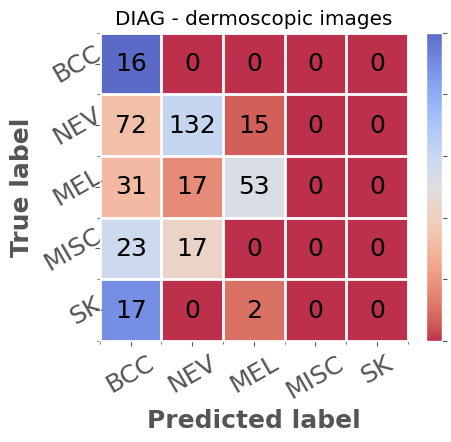

In [529]:
plot_confusion(y_true=test_labels['DIAG'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('DIAG' + ' - dermoscopic images');

In [56]:
test_temp = []
for i in predictions[1]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [57]:
conf_mat = np.zeros(shape=(3, 3))
for i in range(395):
    conf_mat[test_labels['PN'].iloc[i]][np.argmax(predictions[1][i])] += 1

conf_mat

array([[134.,  15.,   7.],
       [  7., 128.,  11.],
       [ 18.,  23.,  52.]])

In [532]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [533]:
label_names = derm_data_group.get_label_by_abbrev('PN').abbrevs.values

In [534]:
spec(conf_mat, 3)

specificity:  [0.89539749 0.84738956 0.94039735]  ||| overall:  0.8943947995886861
senstivity:  [0.85897436 0.87671233 0.55913978]  ||| overall:  0.7649421575625729
precision:  [0.8427673  0.77108434 0.74285714]  ||| overall:  0.7855695919346749


d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


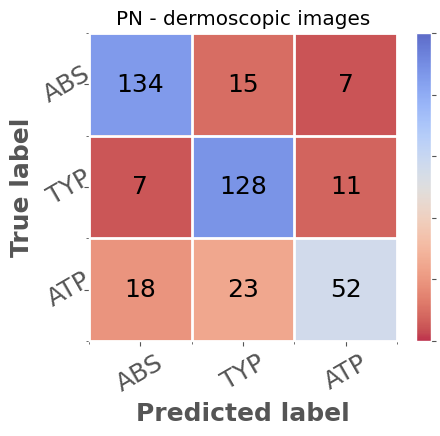

In [535]:
plot_confusion(y_true=test_labels['PN'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('PN' + ' - dermoscopic images');

In [536]:
test_temp = []
for i in predictions[2]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [537]:
conf_mat = np.zeros(shape=(2, 2))
for i in range(395):
    conf_mat[test_labels['BWV'].iloc[i]][np.argmax(predictions[2][i])] += 1

conf_mat

array([[311.,   9.],
       [ 25.,  50.]])

In [538]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [539]:
label_names = derm_data_group.get_label_by_abbrev('BWV').abbrevs.values

In [540]:
spec(conf_mat, 2)

specificity:  [0.66666667 0.971875  ]  ||| overall:  0.8192708333333334
senstivity:  [0.971875   0.66666667]  ||| overall:  0.8192708333333334
precision:  [0.92559524 0.84745763]  ||| overall:  0.8865264326069411


d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


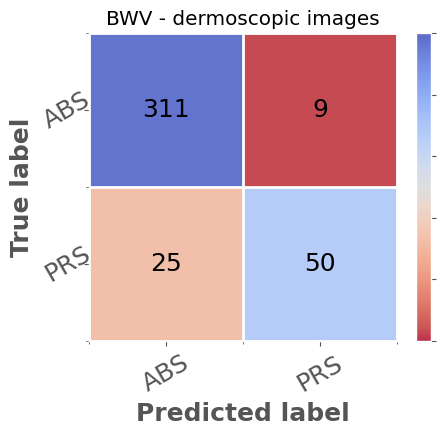

In [541]:
plot_confusion(y_true=test_labels['BWV'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('BWV' + ' - dermoscopic images');

In [542]:
test_temp = []
for i in predictions[3]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [543]:
conf_mat = np.zeros(shape=(3, 3))
for i in range(395):
    conf_mat[test_labels['VS'].iloc[i]][np.argmax(predictions[3][i])] += 1

conf_mat

array([[310.,   3.,   0.],
       [ 28.,  23.,   1.],
       [ 18.,   2.,  10.]])

In [544]:
spec(conf_mat, 3)

specificity:  [0.43902439 0.98542274 0.99726027]  ||| overall:  0.8072358015804287
senstivity:  [0.99041534 0.44230769 0.33333333]  ||| overall:  0.5886854537014281
precision:  [0.87078652 0.82142857 0.90909091]  ||| overall:  0.8671019991244711


In [545]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [546]:
label_names = derm_data_group.get_label_by_abbrev('VS').abbrevs.values

d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


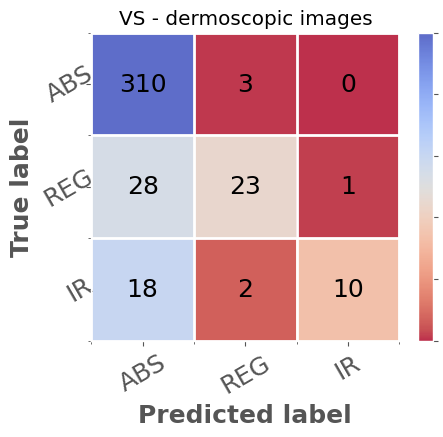

In [547]:
plot_confusion(y_true=test_labels['VS'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('VS' + ' - dermoscopic images');

In [548]:
test_temp = []
for i in predictions[4]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [549]:
conf_mat = np.zeros(shape=(3, 3))
for i in range(395):
    conf_mat[test_labels['PIG'].iloc[i]][np.argmax(predictions[4][i])] += 1

conf_mat

array([[199.,   3.,  21.],
       [ 17.,  27.,   4.],
       [ 41.,   4.,  79.]])

In [550]:
spec(conf_mat, 3)

specificity:  [0.6627907  0.97982709 0.90774908]  ||| overall:  0.8501222881674564
senstivity:  [0.89237668 0.5625     0.63709677]  ||| overall:  0.6973244852692995
precision:  [0.77431907 0.79411765 0.75961538]  ||| overall:  0.7760173659406894


In [551]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [552]:
label_names = derm_data_group.get_label_by_abbrev('PIG').abbrevs.values

d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


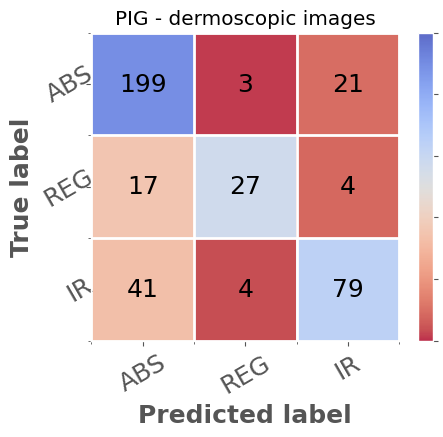

In [553]:
plot_confusion(y_true=test_labels['PIG'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('PIG' + ' - dermoscopic images');

In [554]:
test_temp = []
for i in predictions[5]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [555]:
conf_mat = np.zeros(shape=(3, 3))
for i in range(395):
    conf_mat[test_labels['STR'].iloc[i]][np.argmax(predictions[5][i])] += 1

conf_mat

array([[247.,   1.,   9.],
       [ 12.,  25.,   7.],
       [ 30.,   6.,  58.]])

In [556]:
spec(conf_mat, 3)

specificity:  [0.69565217 0.98005698 0.94684385]  ||| overall:  0.8741843359302072
senstivity:  [0.96108949 0.56818182 0.61702128]  ||| overall:  0.715430862980329
precision:  [0.85467128 0.78125    0.78378378]  ||| overall:  0.8065683546868668


In [557]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [558]:
label_names = derm_data_group.get_label_by_abbrev('STR').abbrevs.values

d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


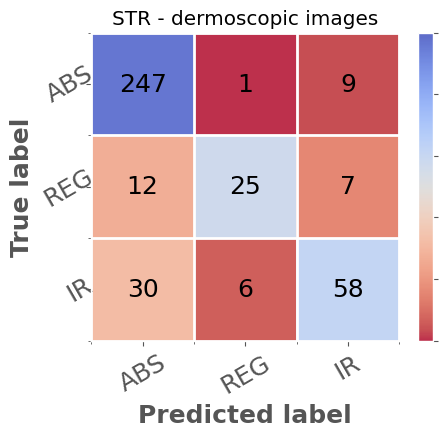

In [559]:
plot_confusion(y_true=test_labels['STR'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('STR' + ' - dermoscopic images');

In [560]:
test_temp = []
for i in predictions[6]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [561]:
conf_mat = np.zeros(shape=(3, 3))
for i in range(395):
    conf_mat[test_labels['DaG'].iloc[i]][np.argmax(predictions[6][i])] += 1

conf_mat

array([[ 62.,  20.,  18.],
       [ 11.,  86.,  21.],
       [ 11.,  23., 143.]])

In [562]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [563]:
spec(conf_mat, 3)

specificity:  [0.92542373 0.84476534 0.82110092]  ||| overall:  0.8637633297350136
senstivity:  [0.62       0.72881356 0.8079096 ]  ||| overall:  0.7189077212806027
precision:  [0.73809524 0.66666667 0.78571429]  ||| overall:  0.7301587301587301


In [564]:
label_names = derm_data_group.get_label_by_abbrev('DaG').abbrevs.values

d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


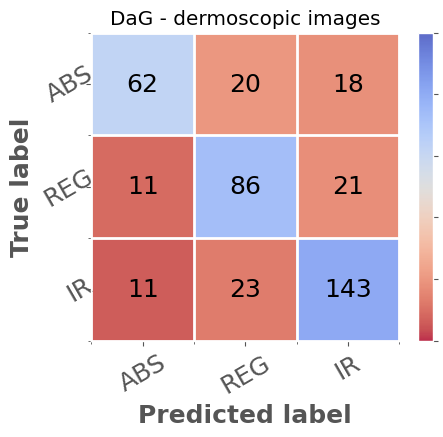

In [565]:
plot_confusion(y_true=test_labels['DaG'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('DaG' + ' - dermoscopic images');

In [566]:
test_temp = []
for i in predictions[7]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [567]:
conf_mat = np.zeros(shape=(2, 2))
for i in range(395):
    conf_mat[test_labels['RS'].iloc[i]][np.argmax(predictions[7][i])] += 1

conf_mat

array([[272.,  17.],
       [ 38.,  68.]])

In [568]:
spec(conf_mat, 2)

specificity:  [0.64150943 0.94117647]  ||| overall:  0.7913429522752498
senstivity:  [0.94117647 0.64150943]  ||| overall:  0.7913429522752498
precision:  [0.87741935 0.8       ]  ||| overall:  0.8387096774193549


In [569]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [570]:
label_names = derm_data_group.get_label_by_abbrev('RS').abbrevs.values

d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


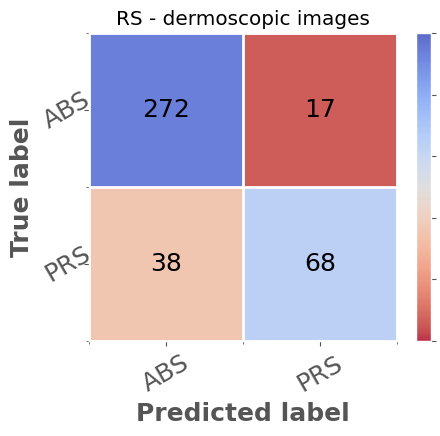

In [571]:
plot_confusion(y_true=test_labels['RS'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('RS' + ' - dermoscopic images');

In [575]:
print(sum(total_spef)/7)
print(sum(total_spen)/7)
print(sum(total_prec)/7)


0.842902048658625
0.7279863523432593
0.812950307410247


In [109]:
history.history.keys()

NameError: name 'history' is not defined

In [110]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

#### Calculating 7-point checklist score to infer presence of Melanoma

In [58]:
pigment_network = [0, 0, 2]
blue_whitish_viel = [0, 2]
vascular_structures = [0, 0, 2]
pigmentation = [0, 0, 1]
streaks = [0, 0, 1]
dots_and_globules = [0, 0, 1]
regression_structures = [0, 1]

In [59]:
test_labels.keys()

dict_keys(['DIAG', 'PN', 'BWV', 'VS', 'PIG', 'STR', 'DaG', 'RS'])

In [60]:
predictions[1][11], predictions[1][11].argmax()
sevenpt_scores = [0 for i in range(395)]
for i in range(395):
    sevenpt_scores[i] = pigment_network[predictions[1][i].argmax()]
    + blue_whitish_viel[predictions[2][i].argmax()]
    + vascular_structures[predictions[3][i].argmax()]
    + pigmentation[predictions[4][i].argmax()]
    + streaks[predictions[5][i].argmax()]
    + dots_and_globules[predictions[6][i].argmax()]
    + regression_structures[predictions[7][i].argmax()]

In [61]:
true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
for i in range(395):
    if test_labels['DIAG'].iloc[i] == 2:
        if sevenpt_scores[i] >= 1:
            true_pos += 1
        else:
            false_neg += 1
    else:
        if sevenpt_scores[i] >= 1:
            false_pos += 1
        else:
            true_neg += 1

In [62]:
true_pos, true_neg, false_pos, false_neg

(53, 277, 17, 48)

In [63]:
true_pos/(true_pos+false_pos)

0.7571428571428571

In [583]:
test_labels['DIAG'][test_labels['DIAG'] == 2].count()

101

In [118]:
datadata = pd.read_csv("D:/COLLEGE\PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0/meta/meta.csv")

In [119]:
datadata.head()

,case_num,diagnosis,seven_point_score,pigment_network,streaks,pigmentation,regression_structures,dots_and_globules,blue_whitish_veil,vascular_structures,level_of_diagnostic_difficulty,elevation,location,sex,management,clinic,derm,case_id,notes
0,1,basal cell carcinoma,0,absent,absent,absent,absent,absent,absent,arborizing,medium,nodular,abdomen,female,excision,NEL/NEL025.JPG,NEL/Nel026.jpg,NaN,NaN
1,2,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,absent,low,palpable,head neck,female,excision,NEL/NEL027.JPG,NEL/Nel028.jpg,NaN,NaN
2,3,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,arborizing,medium,palpable,head neck,female,excision,NEL/Nel032.jpg,NEL/Nel033.jpg,NaN,NaN
3,4,basal cell carcinoma,4,absent,absent,absent,blue areas,irregular,present,within regression,low,palpable,lower limbs,male,excision,NEL/NEL034.JPG,NEL/Nel035.jpg,NaN,NaN
4,5,basal cell carcinoma,1,absent,absent,diffuse irregular,absent,absent,absent,absent,high,palpable,upper limbs,female,excision,NEL/NEL036.JPG,NEL/Nel037.jpg,NaN,NaN


In [120]:
datadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   case_num                        1011 non-null   int64 
 1   diagnosis                       1011 non-null   object
 2   seven_point_score               1011 non-null   int64 
 3   pigment_network                 1011 non-null   object
 4   streaks                         1011 non-null   object
 5   pigmentation                    1011 non-null   object
 6   regression_structures           1011 non-null   object
 7   dots_and_globules               1011 non-null   object
 8   blue_whitish_veil               1011 non-null   object
 9   vascular_structures             1011 non-null   object
 10  level_of_diagnostic_difficulty  1011 non-null   object
 11  elevation                       1011 non-null   object
 12  location                        1011 non-null   

In [121]:
datadata.management.unique()

array(['excision', 'no further examination', 'clinical follow up'],
      dtype=object)

In [122]:
datadata[['diagnosis', 'seven_point_score', 'elevation', 'location', 'sex', 'management']].head()

,diagnosis,seven_point_score,elevation,location,sex,management
0,basal cell carcinoma,0,nodular,abdomen,female,excision
1,basal cell carcinoma,1,palpable,head neck,female,excision
2,basal cell carcinoma,1,palpable,head neck,female,excision
3,basal cell carcinoma,4,palpable,lower limbs,male,excision
4,basal cell carcinoma,1,palpable,upper limbs,female,excision
